# Bollinger Bands Mean Reversion Strategy: Deep Dive

**December 15, 2024 • Karthik Bibireddy**

![Bollinger Bands Chart](https://images.unsplash.com/photo-1611974789855-9c2a0a7236a3?w=800&h=400&fit=crop)

## Overview

The Bollinger Bands Mean Reversion Strategy is a contrarian approach designed to profit from price returning to its statistical mean after reaching extreme overbought or oversold conditions. This strategy works best in ranging markets and can generate consistent profits over 3-6 week periods when applied correctly.

### What to Expect in This Deep Dive

This notebook provides a comprehensive exploration of the Bollinger Bands mean reversion strategy:

1. **Mathematical Foundations**: Understanding the core mathematics behind Bollinger Bands, including standard deviation calculations, band construction, and the %B indicator
2. **Strategy Development**: How to translate mathematical concepts into trading rules, with multiple strategy variations and trade-off analysis
3. **Backtesting**: Implementation and execution of the strategy on historical data
4. **Performance Analysis**: How to interpret results and compare strategy performance against baselines
5. **Practical Insights**: Key takeaways and considerations for real-world application

### Table of Contents

1. [Setup and Imports](#setup)
2. [Math Foundations](#math-foundations)
3. [Strategy](#strategy)
4. [Backtesting](#backtesting)
5. [Strategy Performance](#strategy-performance)
6. [Final Notes and Conclusion](#conclusion)

## 1. Setup and Imports {#setup}

First, let's install and import all necessary libraries.

In [12]:
# Install backtrader if not already installed
# !pip install backtrader matplotlib pandas numpy

In [13]:
import backtrader as bt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("Backtrader version:", bt.__version__)
print("All libraries imported successfully!")

Backtrader version: 1.9.78.123
All libraries imported successfully!


## 2. Math Foundations {#math-foundations}

### Core Mathematical Components

Bollinger Bands are volatility-based indicators that create a dynamic envelope around price. They consist of three components:

**1. Middle Band (SMA)**
The middle band is a simple moving average of closing prices:

$$MB_t = \frac{1}{n} \sum_{i=t-n+1}^{t} P_i$$

Where:
- $P_i$ = Price at period $i$
- $n$ = Number of periods (typically 20)
- $t$ = Current period

**2. Standard Deviation (σ)**
Measures price volatility over the same period:

$$\sigma_t = \sqrt{\frac{1}{n} \sum_{i=t-n+1}^{t} (P_i - MB_t)^2}$$

**3. Upper and Lower Bands**
Bands are positioned a fixed number of standard deviations from the middle band:

$$UB_t = MB_t + (k \times \sigma_t)$$
$$LB_t = MB_t - (k \times \sigma_t)$$

Where $k$ is the standard deviation multiplier (typically 2.0).

**4. %B Indicator**
Measures where price is relative to the bands:

$$\%B_t = \frac{P_t - LB_t}{UB_t - LB_t}$$

Interpretation:
- $\%B < 0$: Price below lower band (oversold, potential buy signal)
- $0 \leq \%B \leq 1$: Price within bands (normal range)
- $\%B > 1$: Price above upper band (overbought, potential sell signal)

### Visualization: Bollinger Bands System

The following visualization demonstrates how all components interact on a sample price chart:

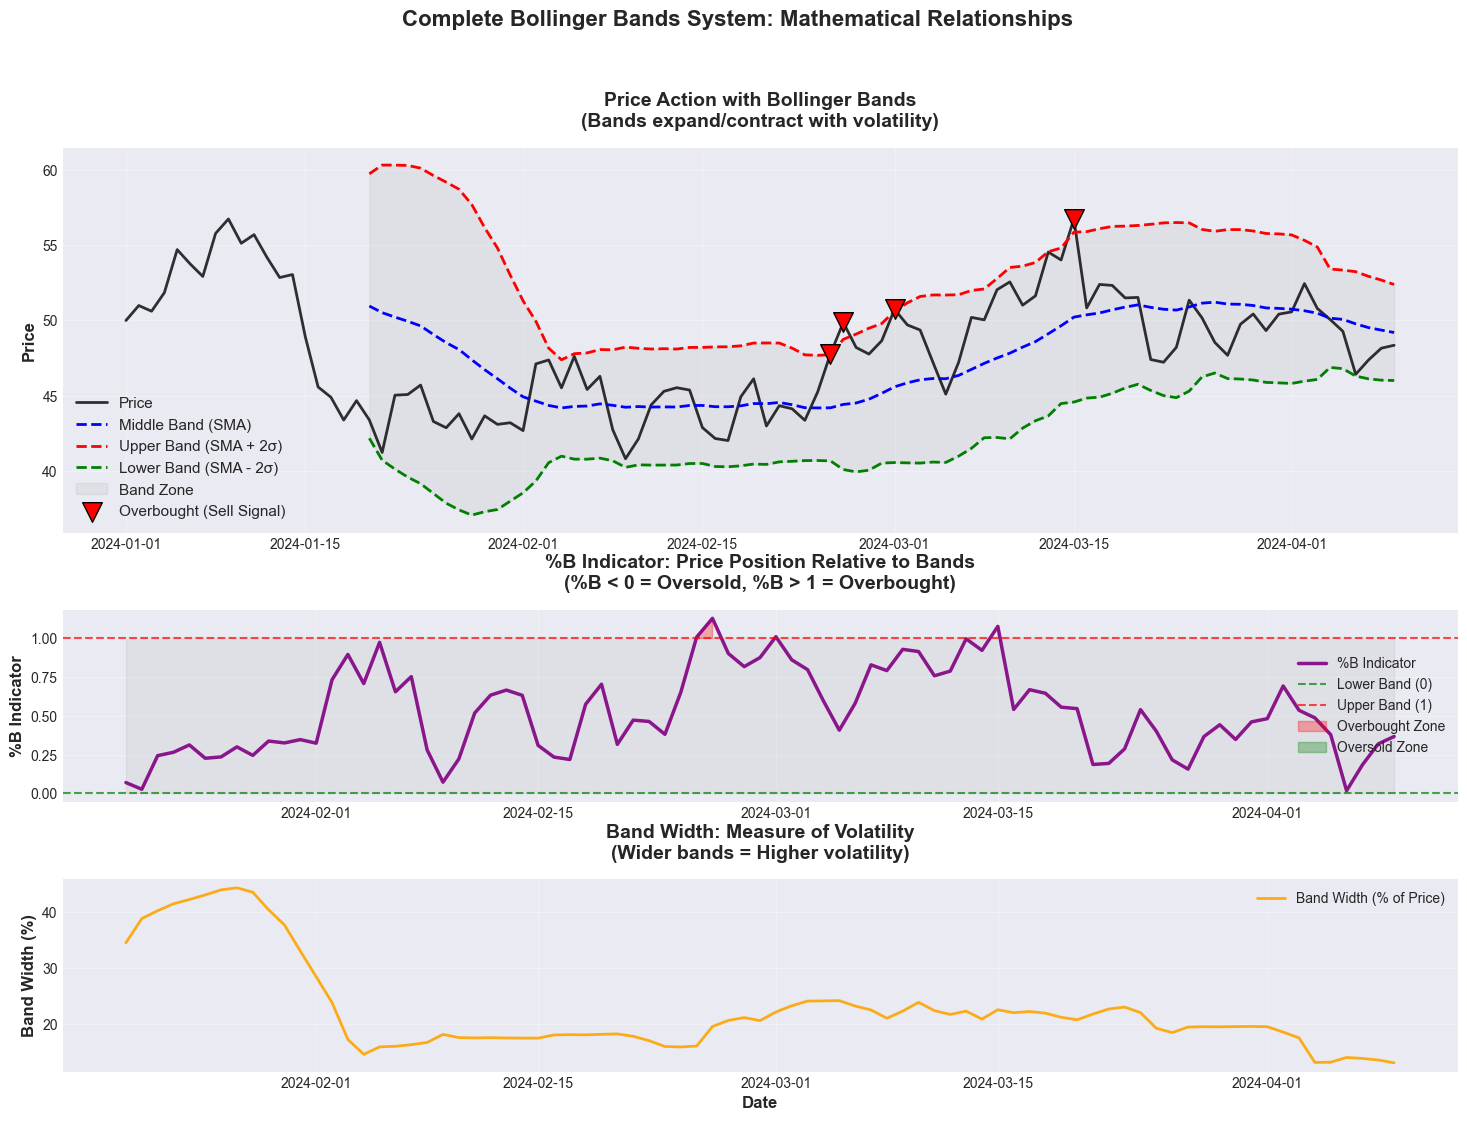


COMPLETE BOLLINGER BANDS SYSTEM SUMMARY

1. Middle Band = SMA(n) = (1/n) × Σ(P_i)  [Simple Moving Average]
2. Standard Deviation = σ = √[(1/n) × Σ(P_i - MB)²]  [Volatility measure]
3. Upper Band = MB + (k × σ)  [Typically k = 2.0]
4. Lower Band = MB - (k × σ)  [Typically k = 2.0]
5. %B = (Price - Lower Band) / (Upper Band - Lower Band)  [Position indicator]

Trading Signals:
  • Oversold: Price touches lower band, %B < 0 (buy signal)
  • Overbought: Price touches upper band, %B > 1 (sell signal)
  • Mean Reversion: Price returns toward middle band


In [14]:
# Comprehensive Bollinger Bands Visualization
def visualize_bollinger_bands_system():
    """Show the complete Bollinger Bands system with price, bands, and %B indicator."""
    np.random.seed(42)
    # Generate sample price data with mean-reverting behavior
    n_periods = 100
    dates = pd.date_range(start='2024-01-01', periods=n_periods, freq='D')
    base_price = 50
    prices = [base_price]
    
    for i in range(1, n_periods):
        change = np.random.normal(0, 2)
        mean_reversion = -0.1 * (prices[-1] - base_price)
        new_price = prices[-1] + change + mean_reversion
        prices.append(max(new_price, 30))
    
    df = pd.DataFrame({'date': dates, 'close': prices})
    
    # Calculate Bollinger Bands
    period = 20
    df['sma'] = df['close'].rolling(window=period).mean()
    df['std'] = df['close'].rolling(window=period).std()
    df['upper'] = df['sma'] + (2 * df['std'])
    df['lower'] = df['sma'] - (2 * df['std'])
    df['percent_b'] = (df['close'] - df['lower']) / (df['upper'] - df['lower'])
    
    # Valid indices (after initialization)
    valid_start = period - 1
    valid_indices = np.arange(valid_start, n_periods)
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1], hspace=0.3)
    
    # Plot 1: Price and Bollinger Bands
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df['date'], df['close'], label='Price', linewidth=2, color='black', alpha=0.8)
    ax1.plot(df['date'], df['sma'], label='Middle Band (SMA)', linestyle='--', color='blue', linewidth=2)
    ax1.plot(df['date'], df['upper'], label='Upper Band (SMA + 2σ)', linestyle='--', color='red', linewidth=2)
    ax1.plot(df['date'], df['lower'], label='Lower Band (SMA - 2σ)', linestyle='--', color='green', linewidth=2)
    ax1.fill_between(df['date'], df['upper'], df['lower'], alpha=0.1, color='gray', label='Band Zone')
    
    # Mark oversold and overbought areas
    oversold_idx = df[df['close'] <= df['lower']].index
    overbought_idx = df[df['close'] >= df['upper']].index
    
    if len(oversold_idx) > 0:
        ax1.scatter(df.loc[oversold_idx, 'date'], df.loc[oversold_idx, 'close'], 
                   color='green', s=200, marker='^', label='Oversold (Buy Signal)', zorder=5, edgecolors='black')
    
    if len(overbought_idx) > 0:
        ax1.scatter(df.loc[overbought_idx, 'date'], df.loc[overbought_idx, 'close'], 
                   color='red', s=200, marker='v', label='Overbought (Sell Signal)', zorder=5, edgecolors='black')
    
    ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
    ax1.set_title('Price Action with Bollinger Bands\n(Bands expand/contract with volatility)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax1.legend(loc='best', fontsize=11, framealpha=0.9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: %B Indicator
    ax2 = fig.add_subplot(gs[1])
    ax2.plot(df.loc[valid_indices, 'date'], df.loc[valid_indices, 'percent_b'], 
             label='%B Indicator', linewidth=2.5, color='purple', alpha=0.9)
    ax2.axhline(y=0, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Lower Band (0)')
    ax2.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Upper Band (1)')
    ax2.fill_between(df.loc[valid_indices, 'date'], 0, 1, alpha=0.1, color='gray')
    ax2.fill_between(df.loc[valid_indices, 'date'], df.loc[valid_indices, 'percent_b'], 1, 
                     where=(df.loc[valid_indices, 'percent_b'] > 1), alpha=0.3, color='red', label='Overbought Zone')
    ax2.fill_between(df.loc[valid_indices, 'date'], 0, df.loc[valid_indices, 'percent_b'], 
                     where=(df.loc[valid_indices, 'percent_b'] < 0), alpha=0.3, color='green', label='Oversold Zone')
    ax2.set_ylabel('%B Indicator', fontsize=12, fontweight='bold')
    ax2.set_title('%B Indicator: Price Position Relative to Bands\n(%B < 0 = Oversold, %B > 1 = Overbought)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax2.legend(loc='best', fontsize=10, framealpha=0.9)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Band Width (Volatility)
    ax3 = fig.add_subplot(gs[2])
    band_width = (df['upper'] - df['lower']) / df['sma'] * 100
    ax3.plot(df.loc[valid_indices, 'date'], band_width.loc[valid_indices], 
             label='Band Width (% of Price)', linewidth=2, color='orange', alpha=0.9)
    ax3.set_ylabel('Band Width (%)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax3.set_title('Band Width: Measure of Volatility\n(Wider bands = Higher volatility)', 
                  fontsize=14, fontweight='bold', pad=15)
    ax3.legend(loc='best', fontsize=10, framealpha=0.9)
    ax3.grid(True, alpha=0.3)
    
    plt.suptitle('Complete Bollinger Bands System: Mathematical Relationships', 
                 fontsize=16, fontweight='bold', y=0.995)
    return fig

fig_complete = visualize_bollinger_bands_system()
plt.show()

print("\n" + "="*70)
print("COMPLETE BOLLINGER BANDS SYSTEM SUMMARY")
print("="*70)
print("\n1. Middle Band = SMA(n) = (1/n) × Σ(P_i)  [Simple Moving Average]")
print("2. Standard Deviation = σ = √[(1/n) × Σ(P_i - MB)²]  [Volatility measure]")
print("3. Upper Band = MB + (k × σ)  [Typically k = 2.0]")
print("4. Lower Band = MB - (k × σ)  [Typically k = 2.0]")
print("5. %B = (Price - Lower Band) / (Upper Band - Lower Band)  [Position indicator]")
print("\nTrading Signals:")
print("  • Oversold: Price touches lower band, %B < 0 (buy signal)")
print("  • Overbought: Price touches upper band, %B > 1 (sell signal)")
print("  • Mean Reversion: Price returns toward middle band")
print("="*70)

## 3. Strategy {#strategy}

### How to Use Bollinger Bands Mathematics to Form a Trading Strategy

The mathematical components of Bollinger Bands can be combined into mean reversion trading strategies. The core idea is to buy when price is oversold (touches lower band) and sell when price is overbought (touches upper band), expecting price to revert to the mean (middle band).

### Strategy Variations

We'll explore three variations of the Bollinger Bands mean reversion strategy, each with different trade-offs:

| Strategy Variation | Entry Rules | Exit Rules | Risk Management | Best For |
|-------------------|-------------|------------|-----------------|----------|
| **Conservative (RSI-Confirmed)** | Price touches band + %B confirmation + RSI < 30 (long) or RSI > 70 (short) | Target 1: Middle band (50%), Target 2: Opposite band (remaining 50%), Stop loss (2.5%) | 2.5% stop loss, scaled exits | Ranging markets, lower volatility |
| **Aggressive (Band-Touch Only)** | Price touches lower/upper band only | Target: Middle band (100%), Stop loss (2%) | 2% stop loss, single target | High-frequency trades, trending-with-corrections |
| **Volatility-Adjusted** | Band touch + RSI + Band width expansion filter | Dynamic targets based on band width, Trailing stop | 2-3% stop, trailing after 1% gain | Volatile ranging markets |

### Trade-Offs Analysis

| Factor | Conservative | Aggressive | Volatility-Adjusted |
|--------|-------------|------------|---------------------|
| **Win Rate** | Higher (55-65%) | Lower (45-55%) | Moderate (50-60%) |
| **Trade Frequency** | Lower (requires RSI confirmation) | Higher (band touch only) | Moderate (filters reduce signals) |
| **Risk per Trade** | Moderate (2.5% stop) | Higher (2% stop, tighter) | Moderate (2-3% dynamic stop) |
| **Profit Potential** | Moderate (scaled exits) | Lower (single middle band target) | Higher (dynamic targets) |
| **Market Conditions** | Ranging markets | Ranging/choppy markets | Volatile ranging markets |
| **Drawdown Risk** | Lower (RSI filter reduces false signals) | Higher (more trades, tighter stops) | Moderate (volatility filter helps) |

### Recommended: Conservative Strategy

For most traders, the **Conservative (RSI-Confirmed)** strategy offers the best balance of risk and reward. It uses:
- **RSI Filter**: Only trades when RSI confirms oversold/overbought conditions (< 30 for longs, > 70 for shorts)
- **%B Confirmation**: Ensures price has actually penetrated the band (%B < 0 for longs, %B > 1 for shorts)
- **Scaled Exits**: Take 50% profit at middle band, remaining 50% at opposite band
- **Stop Loss**: 2.5% to allow for normal volatility while protecting capital

This strategy is implemented in the backtesting section below.

In [15]:
class BollingerBandsMeanReversion(bt.Strategy):
    """
    Conservative (RSI-Confirmed) Bollinger Bands Mean Reversion Strategy
    
    This is the recommended Conservative strategy from Section 3.
    
    Entry Rules:
    - Long: Price touches lower band + %B < 0 + RSI < 30
    - Short: Price touches upper band + %B > 1 + RSI > 70
    
    Exit Rules:
    - Target 1: Middle band (50% position)
    - Target 2: Opposite band (remaining 50%)
    - Stop Loss: 2.5% below/above entry
    
    Risk Management:
    - 2.5% stop loss (allows for normal volatility)
    - Scaled exits (50% at target 1, remaining 50% at target 2)
    - RSI filter reduces false signals
    """
    
    params = (
        ('bb_period', 20),      # Bollinger Bands period
        ('bb_devfactor', 2.0),  # Bollinger Bands standard deviation multiplier
        ('rsi_period', 14),     # RSI period
        ('rsi_oversold', 30),   # RSI oversold level
        ('rsi_overbought', 70), # RSI overbought level
        ('stop_loss_pct', 0.025), # Stop loss percentage (2.5%)
        ('printlog', False),    # Print trade logs
    )
    
    def __init__(self):
        # Bollinger Bands indicator
        self.bb = bt.indicators.BollingerBands(
            self.data.close,
            period=self.params.bb_period,
            devfactor=self.params.bb_devfactor
        )
        
        # RSI indicator
        self.rsi = bt.indicators.RSI(
            self.data.close,
            period=self.params.rsi_period
        )
        
        # Calculate %B indicator
        self.percent_b = (self.data.close - self.bb.lines.bot) / (self.bb.lines.top - self.bb.lines.bot)
        
        # Track orders and positions
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sellprice = None
        self.sellcomm = None
        
        # Track partial exits
        self.target1_hit = False
        self.entry_price = None
        self.stop_loss_price = None
        self.target1_price = None
        self.target2_price = None
    
    def log(self, txt, dt=None):
        """Logging function."""
        if self.params.printlog:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()}: {txt}')
    
    def notify_order(self, order):
        """Execute when order status changes."""
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED, Price: {order.executed.price:.2f}, '
                        f'Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}')
                self.sellprice = order.executed.price
                self.sellcomm = order.executed.comm
        
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        self.order = None
    
    def notify_trade(self, trade):
        """Execute when trade is closed."""
        if not trade.isclosed:
            return
        
        self.log(f'OPERATION PROFIT, GROSS: {trade.pnl:.2f}, NET: {trade.pnlcomm:.2f}')
    
    def next(self):
        """Execute on each bar."""
        # Skip if indicators not ready
        if len(self.data) < max(self.params.bb_period, self.params.rsi_period):
            return
        
        # Get current values
        current_price = self.data.close[0]
        upper_band = self.bb.lines.top[0]
        lower_band = self.bb.lines.bot[0]
        middle_band = self.bb.lines.mid[0]
        rsi_value = self.rsi[0]
        percent_b_value = self.percent_b[0]
        
        # Skip if bands not calculated (NaN)
        if np.isnan(upper_band) or np.isnan(lower_band) or np.isnan(rsi_value):
            return
        
        # Check for exit conditions first
        if self.position:
            # Check stop loss
            if self.position.size > 0:  # Long position
                if current_price <= self.stop_loss_price:
                    self.log(f'STOP LOSS HIT (Long), Price: {current_price:.2f}')
                    self.close()
                    self._reset_targets()
                    return
                
                # Check target 1 (middle band) - close 50%
                if not self.target1_hit and current_price >= self.target1_price:
                    self.log(f'TARGET 1 HIT (Long), Price: {current_price:.2f}, Closing 50%')
                    size = int(self.position.size * 0.5)
                    if size > 0:
                        self.sell(size=size)
                        self.target1_hit = True
                
                # Check target 2 (upper band) - close remaining
                if self.target1_hit and current_price >= self.target2_price:
                    self.log(f'TARGET 2 HIT (Long), Price: {current_price:.2f}, Closing remaining')
                    self.close()
                    self._reset_targets()
                    return
            
            elif self.position.size < 0:  # Short position
                if current_price >= self.stop_loss_price:
                    self.log(f'STOP LOSS HIT (Short), Price: {current_price:.2f}')
                    self.close()
                    self._reset_targets()
                    return
                
                # Check target 1 (middle band) - close 50%
                if not self.target1_hit and current_price <= self.target1_price:
                    self.log(f'TARGET 1 HIT (Short), Price: {current_price:.2f}, Closing 50%')
                    size = int(abs(self.position.size) * 0.5)
                    if size > 0:
                        self.buy(size=size)
                        self.target1_hit = True
                
                # Check target 2 (lower band) - close remaining
                if self.target1_hit and current_price <= self.target2_price:
                    self.log(f'TARGET 2 HIT (Short), Price: {current_price:.2f}, Closing remaining')
                    self.close()
                    self._reset_targets()
                    return
        
        # Entry signals (only if no position)
        if not self.position:
            # Long entry: Oversold condition
            if (current_price <= lower_band * 1.01 and  # Price touches lower band
                percent_b_value < 0 and  # %B below 0
                rsi_value < self.params.rsi_oversold):  # RSI oversold
                
                # Calculate entry, stop loss, and targets
                self.entry_price = current_price
                self.stop_loss_price = lower_band * (1 - self.params.stop_loss_pct)
                self.target1_price = middle_band
                self.target2_price = upper_band
                self.target1_hit = False
                
                self.log(f'LONG SIGNAL: Price={current_price:.2f}, Lower Band={lower_band:.2f}, '
                        f'%B={percent_b_value:.2f}, RSI={rsi_value:.2f}')
                
                # Enter long position (use 95% of available cash)
                size = int((self.broker.getcash() * 0.95) / current_price)
                if size > 0:
                    self.buy(size=size)
            
            # Short entry: Overbought condition
            elif (current_price >= upper_band * 0.99 and  # Price touches upper band
                  percent_b_value > 1 and  # %B above 1
                  rsi_value > self.params.rsi_overbought):  # RSI overbought
                
                # Calculate entry, stop loss, and targets
                self.entry_price = current_price
                self.stop_loss_price = upper_band * (1 + self.params.stop_loss_pct)
                self.target1_price = middle_band
                self.target2_price = lower_band
                self.target1_hit = False
                
                self.log(f'SHORT SIGNAL: Price={current_price:.2f}, Upper Band={upper_band:.2f}, '
                        f'%B={percent_b_value:.2f}, RSI={rsi_value:.2f}')
                
                # Enter short position
                size = int((self.broker.getcash() * 0.95) / current_price)
                if size > 0:
                    self.sell(size=size)
    
    def _reset_targets(self):
        """Reset target tracking."""
        self.target1_hit = False
        self.entry_price = None
        self.stop_loss_price = None
        self.target1_price = None
        self.target2_price = None
    
    def stop(self):
        """Called at the end of backtest."""
        self.log(f'Ending Value: {self.broker.getvalue():.2f}', None)

print("Strategy class defined successfully!")

Strategy class defined successfully!


## 4. Backtesting {#backtesting}

This section contains the complete backtesting implementation. Run this cell to execute the strategy on historical data.

In [16]:
# Complete Backtesting Implementation
# This cell contains all functions and execution code to run the strategy

def load_ticker_data(ticker, csv_path='datasets/ohlc.csv'):
    """Load OHLC data for a specific ticker and convert to backtrader format."""
    df = pd.read_csv(csv_path)
    ticker_df = df[df['ticker'] == ticker].copy()
    if len(ticker_df) == 0:
        raise ValueError(f"No data found for ticker: {ticker}")
    ticker_df['date'] = pd.to_datetime(ticker_df['date'])
    ticker_df = ticker_df.rename(columns={'date': 'datetime'})
    ticker_df = ticker_df.set_index('datetime')
    ticker_df = ticker_df[['open', 'high', 'low', 'close', 'volume']].sort_index()
    return ticker_df

def run_backtest(ticker, strategy_class, initial_cash=100000, commission=0.001):
    """Run backtest for a specific ticker and strategy."""
    data_df = load_ticker_data(ticker)
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    data = bt.feeds.PandasData(dataname=data_df)
    cerebro.adddata(data)
    cerebro.broker.setcash(initial_cash)
    cerebro.broker.setcommission(commission=commission)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    
    print(f"\n{'='*50}")
    print(f"Running backtest for {ticker}")
    print(f"{'='*50}")
    results = cerebro.run()
    
    final_value = cerebro.broker.getvalue()
    strat = results[0]
    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', 0)
    drawdown = strat.analyzers.drawdown.get_analysis()
    returns = strat.analyzers.returns.get_analysis()
    trades = strat.analyzers.trades.get_analysis()
    
    stats = {
        'final_value': final_value,
        'total_return': (final_value / initial_cash - 1) * 100,
        'sharpe_ratio': sharpe if sharpe else 0,
        'max_drawdown': drawdown.get('max', {}).get('drawdown', 0),
        'total_trades': trades.get('total', {}).get('total', 0),
        'won': trades.get('won', {}).get('total', 0),
        'lost': trades.get('lost', {}).get('total', 0),
        'win_rate': (trades.get('won', {}).get('total', 0) / 
                    max(trades.get('total', {}).get('total', 1), 1)) * 100
    }
    
    return cerebro, final_value, stats

# Run backtests on multiple tickers
baseline_tickers = ['SPY', 'QQQ', 'GLD', 'IAU']
stock_tickers = ['AMZN', 'NVDA', 'TSLA']

baseline_results = {}
for ticker in baseline_tickers:
    try:
        _, final_value, stats = run_backtest(ticker, BollingerBandsMeanReversion)
        baseline_results[ticker] = stats
        print(f"{ticker}: Final Value = ${final_value:.2f}, Return = {stats['total_return']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")

print("\n" + "="*50)
print("Individual Stocks Results:")
print("="*50)

stock_results = {}
for ticker in stock_tickers:
    try:
        _, final_value, stats = run_backtest(ticker, BollingerBandsMeanReversion)
        stock_results[ticker] = stats
        print(f"{ticker}: Final Value = ${final_value:.2f}, Return = {stats['total_return']:.2f}%")
    except Exception as e:
        print(f"Error backtesting {ticker}: {e}")


Running backtest for SPY
SPY: Final Value = $110377.01, Return = 10.38%

Running backtest for QQQ
QQQ: Final Value = $101530.40, Return = 1.53%

Running backtest for GLD
GLD: Final Value = $77202.29, Return = -22.80%

Running backtest for IAU
IAU: Final Value = $65210.95, Return = -34.79%

Individual Stocks Results:

Running backtest for AMZN
AMZN: Final Value = $88997.86, Return = -11.00%

Running backtest for NVDA
NVDA: Final Value = $63014.54, Return = -36.99%

Running backtest for TSLA
TSLA: Final Value = $71207.88, Return = -28.79%


## 5. Strategy Performance {#strategy-performance}

### Key Performance Metrics

**Total Return**: Percentage gain/loss over the entire backtest period
- Positive = Strategy outperformed cash
- Negative = Strategy underperformed cash
- Compare to buy-and-hold baseline (e.g., SPY buy-and-hold return)

**Win Rate**: Percentage of profitable trades
- Higher is generally better (target: >50% for mean reversion)
- Win rate alone doesn't tell the full story (need to consider risk/reward)

**Sharpe Ratio**: Risk-adjusted return metric
- > 1.0 = Good risk-adjusted returns
- > 2.0 = Excellent risk-adjusted returns
- < 1.0 = Poor risk-adjusted returns

**Maximum Drawdown**: Largest peak-to-trough decline
- Lower is better (represents worst-case loss)
- Typical range: 5-20% for this strategy

### Comparing to Baseline

**Baseline Comparison**: Compare strategy returns to a simple buy-and-hold approach:
- If strategy return > baseline return → Strategy adds value
- If strategy return < baseline return → Consider market conditions (strategy works best in ranging markets)

**Market Regime Impact**: Mean reversion strategies perform best in:
- Ranging/sideways markets (price oscillates around mean)
- Avoid strong trending markets (price can stay overbought/oversold)
- Watch for band expansion (indicates momentum shift, not mean reversion)

### Performance Visualization

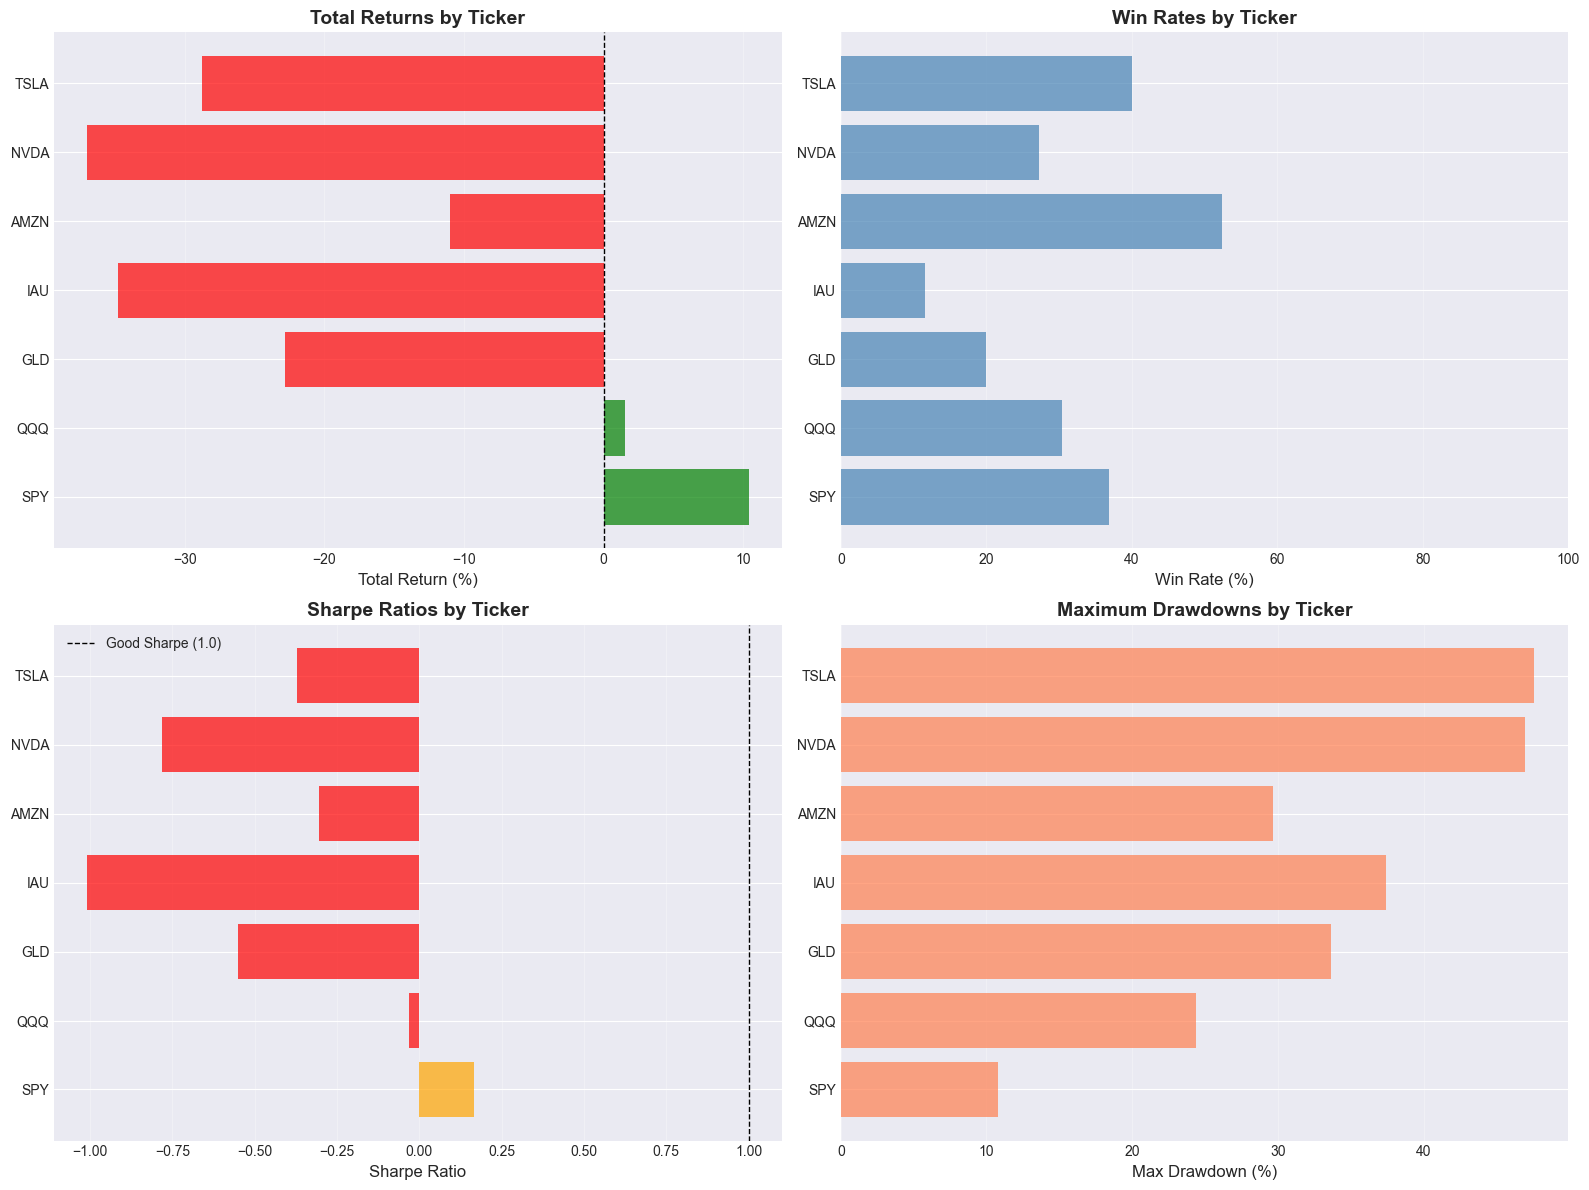

In [17]:
# Performance Visualization
def plot_performance_comparison(baseline_results, stock_results):
    """Plot performance comparison chart."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    all_results = {**baseline_results, **stock_results}
    tickers = list(all_results.keys())
    returns = [all_results[t]['total_return'] for t in tickers]
    win_rates = [all_results[t]['win_rate'] for t in tickers]
    sharpe_ratios = [all_results[t]['sharpe_ratio'] for t in tickers]
    max_drawdowns = [abs(all_results[t]['max_drawdown']) for t in tickers]
    
    # Total Returns
    ax1 = axes[0, 0]
    colors = ['green' if r > 0 else 'red' for r in returns]
    ax1.barh(tickers, returns, color=colors, alpha=0.7)
    ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
    ax1.set_xlabel('Total Return (%)', fontsize=12)
    ax1.set_title('Total Returns by Ticker', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Win Rates
    ax2 = axes[0, 1]
    ax2.barh(tickers, win_rates, color='steelblue', alpha=0.7)
    ax2.set_xlabel('Win Rate (%)', fontsize=12)
    ax2.set_title('Win Rates by Ticker', fontsize=14, fontweight='bold')
    ax2.set_xlim(0, 100)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Sharpe Ratios
    ax3 = axes[1, 0]
    colors_sharpe = ['green' if s > 1 else 'orange' if s > 0 else 'red' for s in sharpe_ratios]
    ax3.barh(tickers, sharpe_ratios, color=colors_sharpe, alpha=0.7)
    ax3.axvline(x=1, color='black', linestyle='--', linewidth=1, label='Good Sharpe (1.0)')
    ax3.set_xlabel('Sharpe Ratio', fontsize=12)
    ax3.set_title('Sharpe Ratios by Ticker', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Max Drawdowns
    ax4 = axes[1, 1]
    ax4.barh(tickers, max_drawdowns, color='coral', alpha=0.7)
    ax4.set_xlabel('Max Drawdown (%)', fontsize=12)
    ax4.set_title('Maximum Drawdowns by Ticker', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    return fig

fig = plot_performance_comparison(baseline_results, stock_results)
plt.show()

## 6. Final Notes and Conclusion {#conclusion}

### Key Takeaways

1. **Bollinger Bands Measure Volatility**: The bands dynamically expand and contract based on price volatility, creating adaptive support and resistance levels. This makes them effective for identifying overbought and oversold conditions.

2. **Strategy Works Best in Ranging Markets**: The mean reversion strategy performs best when markets are ranging (price oscillates around a mean). Avoid using it in strong trending markets where price can stay overbought/oversold for extended periods.

3. **Risk Management is Critical**: Always use stop losses (2-3% recommended), position sizing (1.5-2% of portfolio per trade), and scaled exits (take profits at targets). Never risk more than you can afford to lose.

4. **Multiple Variations Available**: The conservative RSI-confirmed strategy offers the best balance for most traders, but aggressive and volatility-adjusted variations can be explored for different market conditions.

5. **Backtesting Provides Insights, Not Guarantees**: Past performance does not guarantee future results. Use backtesting to understand strategy behavior, but always test with paper trading before deploying real capital.

### Practical Implementation Tips

- **Start with Paper Trading**: Test the strategy with virtual money first
- **Monitor Market Conditions**: Only trade when markets are ranging (not trending)
- **Watch Band Width**: Expanding bands indicate volatility/momentum shifts (avoid trading)
- **Use RSI Confirmation**: Reduces false signals by confirming oversold/overbought conditions
- **Keep a Trading Journal**: Record all trades to learn and improve
- **Stay Disciplined**: Follow your rules, don't let emotions override your strategy

### Final Thoughts

The Bollinger Bands mean reversion strategy is a powerful tool when used correctly in the right market conditions. The mathematical foundations provide a systematic approach to identifying overbought and oversold conditions, and the strategy variations allow adaptation to different market environments. However, success requires discipline, proper risk management, and understanding that this strategy works best in ranging markets, not trending ones.

**Remember**: This notebook is for educational purposes only. Always consult with financial advisors and test thoroughly before deploying real capital.

### Disclaimer

Past performance does not guarantee future results. Trading involves risk of loss. Always use proper risk management and never risk more than you can afford to lose.